In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

PATH = "batik_assets"
IMG_SIZE = (224, 224)

images = []
classes = []
labels = {}

for i, class_name in enumerate(os.listdir(PATH)):
    class_path = os.path.join(PATH, class_name)

    labels[i] = class_name
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        try:
            img = load_img(image_path, target_size=IMG_SIZE)
            img = img_to_array(img)
            images.append(img)
            classes.append(i)
        except Exception:
            continue

images = np.asarray(images).astype(np.float32) / 255.0
classes = np.array(classes)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.2, stratify=classes, random_state=42)

y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    horizontal_flip=True,         
    vertical_flip=True,              
    rotation_range=90, 
)

test_datagen = ImageDataGenerator()

augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    image = np.expand_dims(X_train[i], axis=0)
    label = y_train[i]
    
    aug_iter = train_datagen.flow(image, batch_size=1)
    
    for _ in range(10):
        aug_image = next(aug_iter)[0]
        augmented_images.append(aug_image)
        augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

X_train_augmented = np.concatenate((X_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

train = train_datagen.flow(
    X_train_augmented,
    y_train_augmented,
    batch_size=32,
    shuffle=True
)

test = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32,
    shuffle=False
)

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = Flatten()(vgg_model.output) 
output_layer = Dense(20, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=output_layer)

for layer in vgg_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [19]:
history = model.fit(train, epochs=30, validation_data=test, batch_size=32, callbacks=[early_stopping, reduce_lr])

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.2142 - loss: 3.1686 - val_accuracy: 0.3061 - val_loss: 2.7943 - learning_rate: 0.0010
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.4135 - loss: 2.0560 - val_accuracy: 0.3367 - val_loss: 2.8424 - learning_rate: 0.0010
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.4944 - loss: 1.7199 - val_accuracy: 0.3265 - val_loss: 2.9165 - learning_rate: 0.0010
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.5363 - loss: 1.5527 - val_accuracy: 0.3673 - val_loss: 2.9373 - learning_rate: 0.0010
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.5752 - loss: 1.4535 - val_accuracy: 0.3061 - val_loss: 3.0086 - learning_rate: 0.0010
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.5852 - loss: 1.4069 - val_accuracy: 0.3061 - val_loss: 2.9725 - learning_rate: 0.0010


In [20]:
from tensorflow.keras.optimizers import Adam

for layer in vgg_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_tuning = model.fit(train, epochs=30, validation_data=test, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.4753 - loss: 1.7144 - val_accuracy: 0.2959 - val_loss: 2.4489 - learning_rate: 1.0000e-05
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.5701 - loss: 1.3786 - val_accuracy: 0.3571 - val_loss: 2.4350 - learning_rate: 1.0000e-05
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.6016 - loss: 1.2540 - val_accuracy: 0.3367 - val_loss: 2.5667 - learning_rate: 1.0000e-05
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.6549 - loss: 1.0838 - val_accuracy: 0.3571 - val_loss: 2.5837 - learning_rate: 1.0000e-05
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.6935 - loss: 0.9523 - val_accuracy: 0.3571 - val_loss: 2.6362 - learning_rate: 1.0000e-05
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.7237 - loss: 0.8714 - val_accuracy: 0.3571 - val_loss: 2.7879 - learning_rate: 1.0000e-05
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - acc

In [22]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1) 

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy Score: {accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Accuracy Score: 0.4242


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(labels.values())))


Classification Report:
              precision    recall  f1-score   support

        bali       0.14      0.20      0.17         5
      betawi       0.44      0.80      0.57         5
       celup       1.00      0.60      0.75         5
 cendrawasih       0.67      0.40      0.50         5
      ceplok       0.25      0.40      0.31         5
      ciamis       0.50      0.20      0.29         5
     garutan       1.00      0.20      0.33         5
   gentongan       1.00      0.20      0.33         5
      kawung       0.43      0.60      0.50         5
     keraton       0.33      0.40      0.36         5
       lasem       1.00      0.60      0.75         5
 megamendung       1.00      1.00      1.00         5
      parang       1.00      0.60      0.75         5
  pekalongan       0.00      0.00      0.00         5
    priangan       0.00      0.00      0.00         5
       sekar       1.00      0.40      0.57         5
   sidoluhur       0.40      0.80      0.53         5
   

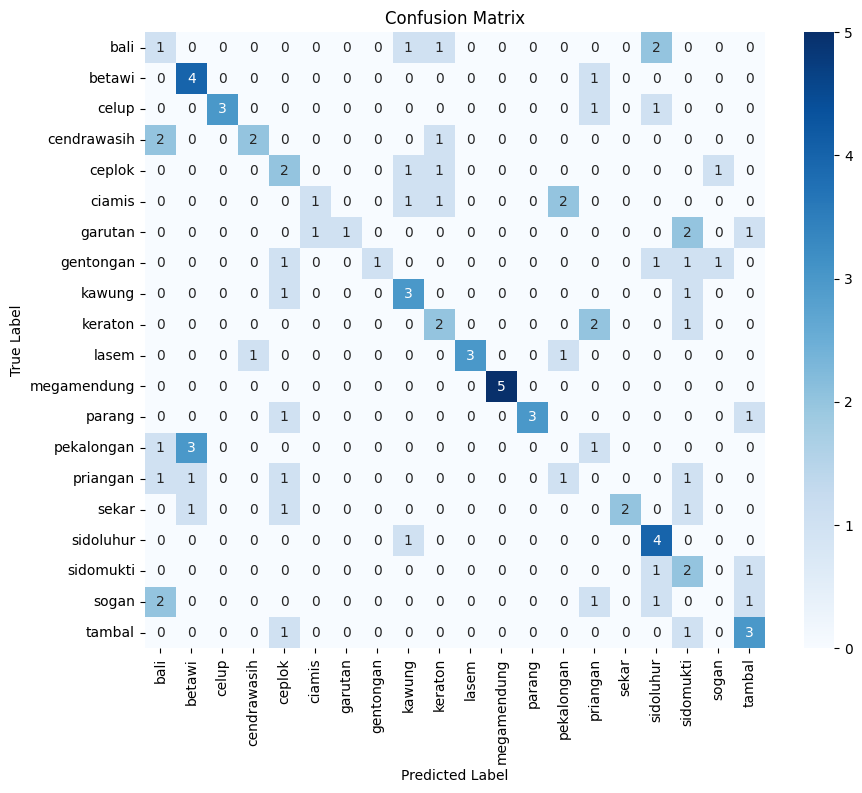

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
model.save("VGG_20_model.h5")